In [1]:
from IPython.display import clear_output
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.models import model_from_json
import time
from keras.callbacks import Callback
import copy

/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 4007)


### Global Variables

In [2]:
GRID_SIZE = 5
TOTALCARS = 3
WAIT_TIME = 5
NUM_ATTR = GRID_SIZE * GRID_SIZE * 3
DEMAND_LIMIT = 4
TERMINAL_REWARD = 10
NUM_ACTIONS = 4

### Helper Functions

In [3]:
def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

def generateCarLocations():
    locations = []
    while len(locations) < TOTALCARS:
        loc = randPair(0,GRID_SIZE)
        if loc not in locations:
            locations.append(loc)
    return locations

def generateRandomDemand(car_locations, demand_dist):
    demand_locations = []
    for x in  range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if random.random() < demand_dist[x][y] and (x,y) not in car_locations:
                demand_locations.append((x,y))
    return demand_locations

class Car(object):
    def __init__(self, location, index):
        self.index = index
        self.location = location
        self.Energy = 100
        self.Utilized = True
        self.QNetwork = None
        self.reward = 0

        
class Customer(object):
    def __init__(self, location):
        self.location = location
        self.transit = False
        self.timer = 10.0


### Grid World Environment

In [4]:
class GridWorld(object):
    def __init__(self):
        self.cars = []
        self.demands = []
        self.demand_distribution = np.zeros((GRID_SIZE,GRID_SIZE))
        self.state = None
        
        #Create the car objects
        locs = generateCarLocations()
        index = 0
        for loc in locs:
            self.cars.append(Car(loc,index))
            index = index + 1
        
        self.createDemandDistribution()
        self.updateDemand()
        self.updateState(self.cars[0])
            
    def dispGrid(self):
        grid = np.zeros((GRID_SIZE,GRID_SIZE), dtype='<U2')
        
        for i in range(0,GRID_SIZE):
            for j in range(0,GRID_SIZE):
                grid[i,j] = '   '

        car_locations = []
        for car in self.cars:
            name = 'C' + str(car.index)
            grid[car.location] = name

        demand_locations = []
        for customer in self.demands:
                grid[customer.location] = ' D ' #Pickup

        return grid
    
    def updateDemand(self):
        lost_demand = 0
        customers_to_delete = []
        for index in range(len(self.demands)):
            customer = self.demands[index]
            customer.timer = customer.timer  - (10.0/(WAIT_TIME*TOTALCARS))
            if(customer.timer <= 0):
                customers_to_delete.append(customer)
            
        for c in customers_to_delete:
            lost_demand = lost_demand + 1 
            self.demands.remove(c)
            
        locs = self.getCarlocs()
        new_demand = generateRandomDemand(locs,self.demand_distribution)
        
        dem_locs = self.getCustomerlocs()
        for d_loc in new_demand:
            if d_loc not in dem_locs and len(self.demands) < DEMAND_LIMIT:
                self.demands.append(Customer(d_loc))
                
        updated_locs = self.getCustomerlocs()
        return lost_demand

    
    def createDemandDistribution(self):
        for x in  range(GRID_SIZE):
            for y in range(GRID_SIZE):
                prob = random.uniform(0, .05)
                self.demand_distribution[x][y] = prob
        #print self.demand_distribution
        
    def getCarlocs(self):
        locs = []
        for car in self.cars:
            locs.append(car.location)
        return locs
    
    def getCustomerlocs(self):
        locs = []
        for customer in self.demands:
            locs.append(customer.location)
        return locs
    
    def step(self,Car,action):
        reward = self.makeMove(Car,action)
        lost_demand = self.updateDemand()
        self.updateState(Car)
        reward = reward - lost_demand
        
        return self.state, reward
    
    def updateState(self,Car):
        state = np.zeros((3,GRID_SIZE,GRID_SIZE)) 
        
        for car in self.cars:
            if car != Car:
                x,y = car.location
                state[0][x][y] = 1
            
        for customer in self.demands:
            x,y = customer.location
            state[1][x][y] = customer.timer
            
        state[2][Car.location[0]][Car.location[1]] = 1
        
        self.state = state
        return self.state
    
    def updatePredictions(self,new_car_locations):
        for row in range(len(self.state[3])):
            for col in range(len(self.state[3])):
                self.state[3][row][col] = 0
                
        for car in new_car_locations:
            x,y = car.location
            self.state[3][x][y] = 1
            
        return self.state
        
    def checkTerminal(self):
        total_reward = 0
        for car in self.cars:
            total_reward = total_reward + car.reward
            
        if total_reward > TERMINAL_REWARD:
            return True
        else:
            return False
        
            
    def makeMove(self,Car,action):
        reward = -0.1
        car_locations = self.getCarlocs()
        customer_locations = self.getCustomerlocs()
        x,y = Car.location
        if action == 0: #Up (row - 1)
            x_new = x - 1
            if(x_new < 0 or x_new > GRID_SIZE -1 or (x_new,y) in car_locations): #If off Board or collision with other car, location stays same
                new_loc = (x,y)
            else:
                new_loc = (x_new,y)   
                reward = self.pickedUpCustomer(Car, new_loc,customer_locations)
            
        elif action == 1: #down (row + 1)
            x_new = x + 1
            if(x_new < 0 or x_new > GRID_SIZE -1 or (x_new,y) in car_locations): #If off Board or collision with other car, location stays same
                new_loc = (x,y)
            else:
                new_loc = (x_new,y)  
                reward = self.pickedUpCustomer(Car, new_loc,customer_locations)
            
        elif action == 2: #Left (Coloumn - 1)
            y_new = y - 1
            if(y_new < 0 or y_new > GRID_SIZE -1 or (x,y_new) in car_locations): #If off Board or collision with other car, location stays same
                new_loc = (x,y)
            else:
                new_loc = (x,y_new)     
                reward = self.pickedUpCustomer(Car, new_loc,customer_locations)
            
        elif action == 3: #right (row + 1)
            y_new = y + 1
            if(y_new < 0 or y_new > GRID_SIZE -1 or (x,y_new) in car_locations): #If off Board or collision with other car, location stays same
                new_loc = (x,y)
            else:
                new_loc = (x,y_new)
                reward = self.pickedUpCustomer(Car, new_loc, customer_locations)
                
        Car.location = new_loc     
        #print ('Reward: ', reward)
        return reward
                
    def pickedUpCustomer(self, Car,new_loc, customer_locations):
        reward = -0.1
        if(new_loc in customer_locations):
            customers_to_delete = []
            for index in range(len(self.demands)):
                Customer = self.demands[index]
                if new_loc == Customer.location:
                    #reward = Customer.timer
                    reward = 1
                    Car.reward = Car.reward + reward 
                    customers_to_delete.append(Customer)
                    
            for c in customers_to_delete:
                self.demands.remove(c)
                
        return reward


        

#### DQN Helper Functions

In [5]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
max_episodes = 5001
gamma = 0.975
epsilon = 1
batchSize = 750
buffer = 25000
switch = True
games_observed = 0
losses = []
reward_discount_factor = 0.8
number_overwritten = 0

total_replay = {}
for index in range(TOTALCARS):
    replay = []
    total_replay[index] = []

#Initialize regular network
model = Sequential()
model.add(Dense(256, init='lecun_uniform', input_shape=(NUM_ATTR,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(256, init='lecun_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(NUM_ACTIONS, init='lecun_uniform'))
model.add(Activation('linear')) 
model.compile(loss="mse", optimizer = Adam(lr=.001))

#Initialize target network
episode_count = 0
model.save_weights('three_agents_' + str(episode_count) + '_epochs_target_network.h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
target_network = model_from_json(loaded_model_json)
target_network.load_weights("three_agents_0_epochs_target_network.h5")


h = 0
while (episode_count < max_episodes):
    status = 1
    grid_world = GridWorld()
    car_list = grid_world.cars
    print (grid_world.dispGrid())
    state = grid_world.state
    while(status == 1):
        intended_actions = []
        initial_states = []
        next_timestep_states = []
        rewards = []
        terminals = []
        
        for car in car_list:

            state = grid_world.updateState(car)
            initial_states.append(state)

            qval = model.predict(state.reshape(1,NUM_ATTR), batch_size=1)
            if (random.random() < epsilon):
                action = np.random.randint(0,NUM_ACTIONS)
            else: 
                action = (np.argmax(qval))
                
            intended_actions.append((car,action))

        for c,a in intended_actions:
            new_state, reward = grid_world.step(c,a)
            next_timestep_states.append(new_state)
            rewards.append((c,reward))
            
            terminal = grid_world.checkTerminal()
            terminals.append(terminal)
            
        print (grid_world.dispGrid())
        
        #End episode if terminal
        if(terminal):
            episode_count = episode_count + 1
            status = 0

        if (len(replay) < buffer): 
            for car in car_list:
                state_a = initial_states[car_list.index(car)]
                action_a = intended_actions[car_list.index(car)][1]
                new_state_a = next_timestep_states[car_list.index(car)]
                terminal_a = terminals[car_list.index(car)]
                
                reward_a = 0
                for c,r in rewards:
                    if c == car:
                        reward_a = reward_a + r
                    else:
                        reward_a = reward_a + (.75 * r)
                
                replay = total_replay[car_list.index(car)]
                replay.append((state_a, action_a, reward_a, new_state_a,terminal_a))
                
                
        else: 
            if switch: 
                games_observed = epochs
                switch = False
                
            for car in car_list:   
                if (h < (buffer-1)):
                    h += 1
                else:
                    number_overwritten = number_overwritten + 1
                    h = 0
                
                state_a = initial_states[car_list.index(car)]
                action_a = intended_actions[car_list.index(car)][1]
                new_state_a = next_timestep_states[car_list.index(car)]
                terminal_a = terminals[car_list.index(car)]
                reward_a = 0
                for c,r in rewards:
                    if c == car:
                        reward_a = reward_a + r
                    else:
                        reward_a = reward_a + (.75 * r)
                        
                replay = total_replay[car_list.index(car)]
                replay[h] = (state_a, action_a, reward_a, new_state_a,terminal_a)

            X_train = []
            y_train = []
            for car in car_list:
                replay = total_replay[car_list.index(car)]
                minibatch = random.sample(replay, batchSize/TOTALCARS)

                for memory in minibatch:
                    old_state_m, action_m, reward_m, new_state_m,terminal_m = memory
                    old_qval = target_network.predict(old_state_m.reshape(1,NUM_ATTR), batch_size=1)
                    newQ = target_network.predict(new_state_m.reshape(1,NUM_ATTR), batch_size=1)
                    maxQ = np.max(newQ)

                    y = np.zeros((1,NUM_ACTIONS))
                    y[:] = old_qval[:]

                    if not terminal_m:
                        update = (reward_m + (gamma * maxQ))
                    else:
                        update = TERMINAL_REWARD

                    y[0][action_m] = update

                    X_train.append(old_state_m.reshape(NUM_ATTR,))
                    y_train.append(y.reshape(NUM_ACTIONS,))

            X_train = np.array(X_train)
            y_train = np.array(y_train)
            print len(X_train)
            print("Game #: %s" % (episode_count,))
            history = LossHistory()
            model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=1,callbacks=[history])
            losses.append(history.losses)

        state = new_state
        clear_output(wait=True)


    if episode_count % 500 == 0:
        model.save_weights('three_agents_' + str(episode_count) + '_epochs_target_network.h5')
        target_network.load_weights("three_agents_" + str(episode_count) + "_epochs_target_network.h5")
        
    if epsilon > 0.05 and len(replay) > buffer: 
        epsilon -= (1/(max_episodes-games_observed))

[[u'  ' u'  ' u'  ' u'  ' u'  ']
 [u' D' u'  ' u'  ' u' D' u'C2']
 [u'  ' u'  ' u'C1' u'  ' u'  ']
 [u'  ' u' D' u'  ' u'  ' u'  ']
 [u'C0' u'  ' u'  ' u' D' u'  ']]


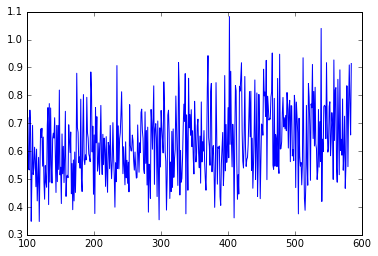

In [8]:
epochs = []
losses_A = []
count = 0
for y in losses:
    losses_A.append(y[0])
    epochs.append(count)
    count = count + 1
index = 100
plt.plot(epochs[index:],losses_A[index:])